In [2]:
library(tidyverse)

theme_set(theme_minimal())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Characterizing binary classifiers

## Decision threshold & sensitivity / specificity

In [3]:
# Simulate n datapoints for the training dataset
n = 1000
class <- rbinom(n, size = 1, prob = .5)

# Simulate the outputs of 2 models
# Note that we don't need to simulate the predictors
M1 <- rnorm(n, mean = class, sd = 0.4)
M2 <- rnorm(n, mean = class, sd = 1)

# Regroup everything in a data frame
df <- data.frame(class = c("healthy (0)", "sick (1)")[class + 1], M1, M2 = M2) %>% 
    mutate(class = factor(class, levels = c("sick (1)","healthy (0)")))

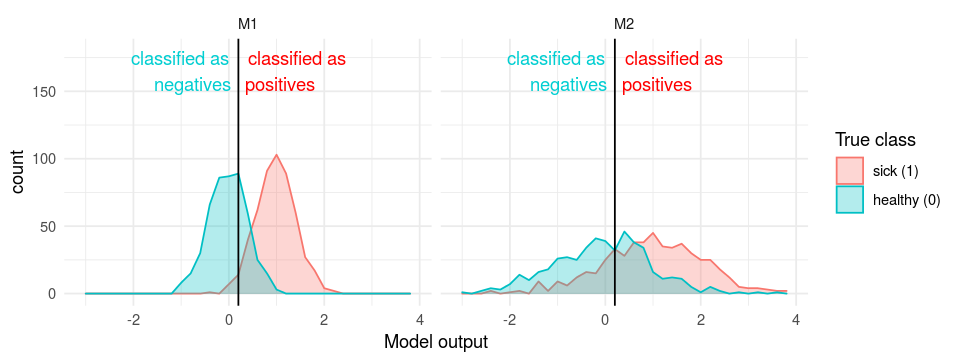

In [4]:
threshold = 0.2

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(data =  df %>% gather(key = model, value = output, starts_with("M")),
       aes(color = class, fill = class, x = output)) +
facet_grid(. ~ model) +
geom_area(aes(y = ..count..), stat = "bin", position = "identity", binwidth = 0.2, alpha = .3) +

# Plot threhsold
geom_vline(xintercept = threshold) +
annotate(geom = "text", label = "classified as\nnegatives", y = 180, x = threshold, vjust = 1, hjust = 1.1, color = "darkturquoise") +
annotate(geom = "text", label = "classified as\npositives", y = 180, x = threshold, vjust = 1, hjust = -0.1, color = "red") +

labs(x = "Model output", color = "True class", fill = "True class")


## Receiving Operator Characteristics (ROC)

We will use the `plotROC` library to plot ROC curves in `ggplot2`.

Tutorial: https://cran.r-project.org/web/packages/plotROC/vignettes/examples.html

In [5]:
# Execute once to install the library
# devtools::install_github("sachsmc/plotROC") 

# Load
library(plotROC)

Warning message:
“Ignoring unknown parameters: fill”Warning message in verify_d(data$d):
“D not labeled 0/1, assuming healthy (0) = 0 and sick (1) = 1!”

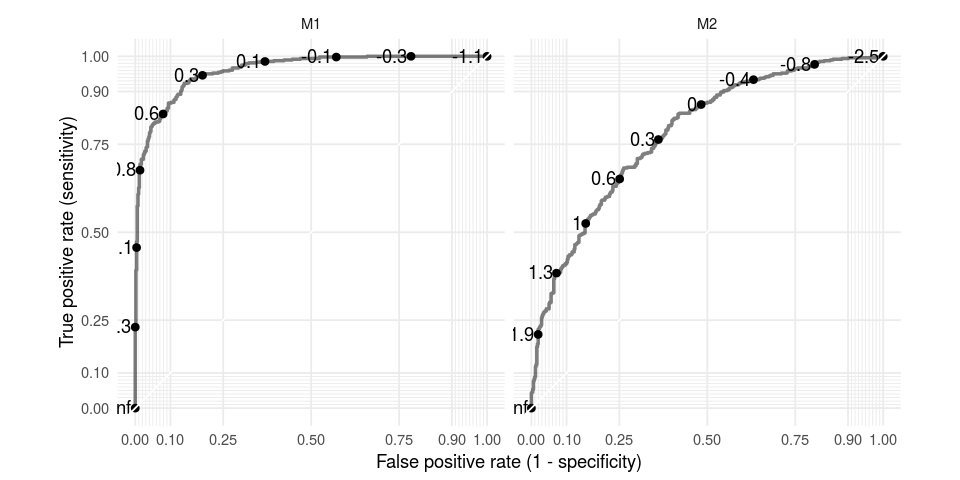

In [344]:
options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(df %>% gather(key = model, value = output, starts_with("M")),
       aes(d = class, m = output)) +
facet_grid(. ~ model) +
geom_roc(linealpha = .5) +
coord_equal() +
style_roc(theme = theme_minimal,
          xlab = "False positive rate (1 - specificity)",
          ylab = "True positive rate (sensitivity)")

# Goodness-of-fit measures

## Simulate data

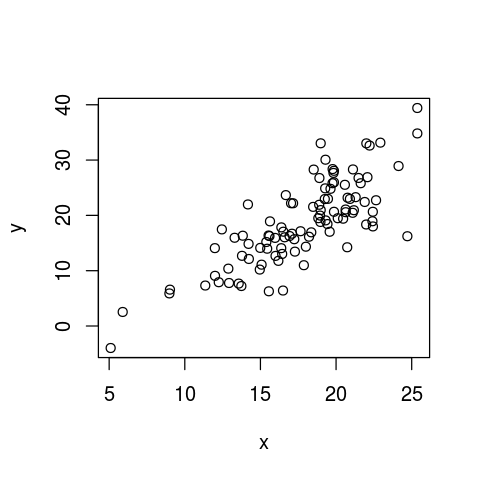

In [7]:
n = 100
x_mean = 17.4
x_sd = 4.3

x = rnorm(n, mean = x_mean, sd = x_sd)
e = rnorm(n, mean = 0, sd = 1*x_sd)
y = -8.2 + 1.5*x + e

plot(x,y)

## Fit models

In [8]:
m1 <- lm("y ~ x")

m0 <- lm("y ~ 1")

## *R*²

In [9]:
# The higher the better
summary(m0)$r.squared # = 0 by definition
summary(m1)$r.squared

[1] 0

[1] 0.6263896

In [14]:
# The output of summary() does correspond to the definition of R²
1-sum(m1$residuals^2)/sum((y-mean(y))^2)

[1] 0.6263896

In [15]:
# !!! Adding predictors always increases R²
# Example when we add a completely random predictor
x2 = rnorm(n, mean = 0, sd = 1)
m2 <- lm("y ~ x + x2")
summary(m2)$r.squared

[1] 0.6264116

In [16]:
# Adjusted R² attempts at penalizing complex models
summary(m2)$adj.r.squared

[1] 0.6187087

## Log-likelihood

In [17]:
# The higher the better
logLik(m0)
logLik(m1)
logLik(m2)

# LL(m1) > LL(m0) => m1 is a better model

'log Lik.' -344.1785 (df=2)

'log Lik.' -294.9514 (df=3)

'log Lik.' -294.9484 (df=4)

## AIC & BIC

In [173]:
# The lower the better
AIC(m0)
AIC(m1)
AIC(m2)

[1] 682.5784

[1] 562.3327

[1] 559.8429

In [174]:
# The lower the better
BIC(m0)
BIC(m1)
BIC(m2)

[1] 687.7887

[1] 570.1482

[1] 570.2636

## Significance tests are model comparisons

In [185]:
summary(m1)
summary(m2)

anova(m0,m1, test="LRT")


Call:
lm(formula = "y ~ x")

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3625 -2.6507 -0.0316  2.6135 10.6112 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.19482    1.67328  -3.105  0.00249 ** 
x            1.36287    0.08895  15.322  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.946 on 98 degrees of freedom
Multiple R-squared:  0.7055,	Adjusted R-squared:  0.7025 
F-statistic: 234.8 on 1 and 98 DF,  p-value: < 2.2e-16



Call:
lm(formula = "y ~ x + x2")

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2615 -2.6936 -0.1181  2.1795 10.8667 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.5766     1.6545  -3.371  0.00108 ** 
x             1.3875     0.0882  15.732  < 2e-16 ***
x2           -0.8315     0.3940  -2.111  0.03738 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.879 on 97 degrees of freedom
Multiple R-squared:  0.7184,	Adjusted R-squared:  0.7126 
F-statistic: 123.7 on 2 and 97 DF,  p-value: < 2.2e-16


Res.Df RSS      Df Sum of Sq Pr(>Chi)   
1 99     5182.677 NA       NA           NA
2 98     1526.328  1 3656.348  5.45917e-53

# Bias-variance tradeoff

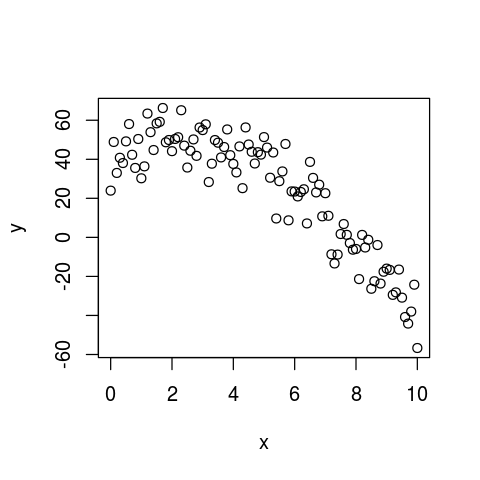

In [33]:
# Let's simulate data with a quadratic trend, and fit it with simpler (linear), correct (quadratic) and
# too complex (cubic) models


# Define a pure quadratic relationship between two variables (without the noise)
b0 = 50
b1 = 3
b2 = -1.2
x = seq(0,10, .1)
y0 = b0 + b1*x + b2*x^2

# Initialize vectors that will store the results
linear_0 = vector("numeric",K)
linear_1 = vector("numeric",K)
linear_2 = vector("numeric",K)

quadratic_0 = vector("numeric",K)
quadratic_1 = vector("numeric",K)
quadratic_2 = vector("numeric",K)

cubic_0 = vector("numeric",K)
cubic_1 = vector("numeric",K)
cubic_2 = vector("numeric",K)

# Number of simulations
K = 1000

for (k in 1:K) {
    
    # Add noise
    y = y0 + rnorm(length(x), 0, 10)
    
    # Fit linear model
    m1 <- lm(y ~ x)
    linear_0[k] <- coef(m1)[["(Intercept)"]]
    linear_1[k] <- coef(m1)[["x"]]
    linear_2[k] <- 0
    
    # Fit quadratic model
    m2 <- lm(y ~ x + I(x^2))
    quadratic_0[k] <- coef(m2)[["(Intercept)"]]
    quadratic_1[k] <- coef(m2)[["x"]]
    quadratic_2[k] <- coef(m2)[["I(x^2)"]]
    
    # Fit cubic model
    m3 <- lm(y ~ x + I(x^2) + I(x^3))
    cubic_0[k] <- coef(m3)[["(Intercept)"]]
    cubic_1[k] <- coef(m3)[["x"]]
    cubic_2[k] <- coef(m3)[["I(x^2)"]]
    
}

# Visualize the last sample, just to get a general idea
options(repr.plot.width = 4, repr.plot.height = 4)
plot(x,y)

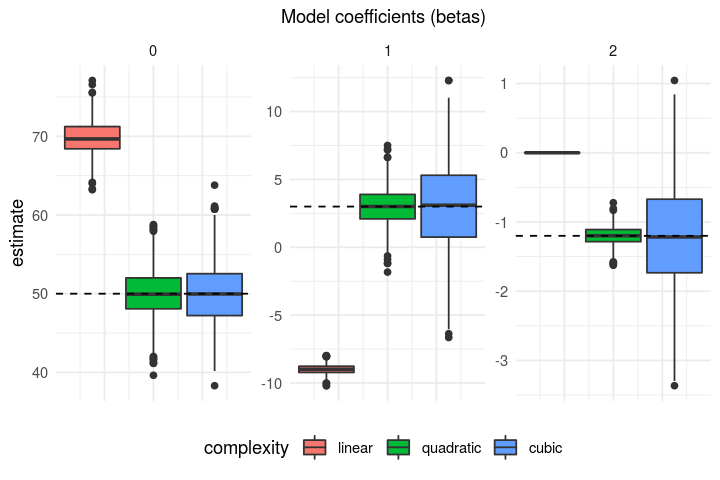

In [24]:
# Visualize the results of the simulations, i.e. the distributions of the coefficients from each model,
# across all simulated samples

df = data.frame(linear_0, linear_1, linear_2, 
                quadratic_0, quadratic_1, quadratic_2,
                cubic_0, cubic_1, cubic_2)

df.plot <- df %>%
    gather(key = parameter, value = estimate, everything()) %>%
    separate(col = parameter, into = c("complexity","parameter"), sep = "_") %>% 
    mutate(complexity = factor(complexity, levels = c("linear","quadratic","cubic")))

options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(df.plot, aes(y = estimate, fill = complexity)) +
facet_wrap(. ~ parameter, scales = "free") +
geom_boxplot() +
geom_hline(data = data.frame(parameter = c(0,1,2), truevalue = c(b0,b1,b2)),
          aes(yintercept = truevalue), linetype = 2, color = "black") +
labs(subtitle = "Model coefficients (betas)") +
theme(plot.subtitle = element_text(hjust = 0.5),
      legend.position = "bottom",
      axis.text.x = element_blank())

# We observe 2 things:
# - the too simple model (linear) has a systematic BIAS over all coefficients
# - the more complex the model, the larger VARIANCE across samples
# => the correct (true) model is the one with the optimal variance-bias tradeoff
# => in practical sessions, where the true model is unknown, we can select the one that offers
#    the best variance-bias tradeoff with the hope that it is the closest to the true model

Warning message:
“Multiple drawing groups in `geom_function()`. Did you use the correct `group`, `colour`, or `fill` aesthetics?”Warning message:
“Multiple drawing groups in `geom_function()`. Did you use the correct `group`, `colour`, or `fill` aesthetics?”

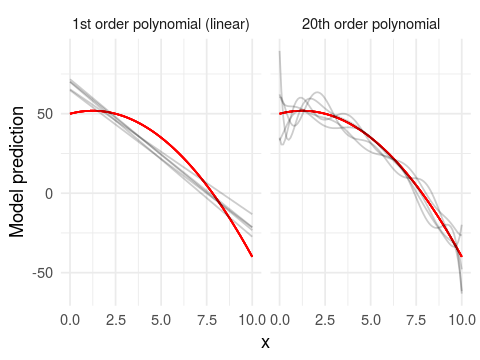

In [38]:
# This is another wat to visualize bias and variance. Notice:
# - how the simple (linear) model is systematically "off" the true relationship (high BIAS) but with
#   very little variation from sample to sample (low VARIANCE)
# - how the more complex (high order polynomial) model can replicate the true pattern on average (low BIAS)
#   but with lots of variation from sample to sample (high VARIANCE)

df <- data.frame()
for (k in 1:5) {
    y = y0 + rnorm(length(x), 0, 20)
    
    m1 <- lm(y ~ x)
    df <- bind_rows(df, data.frame(complexity = "1st order polynomial (linear)", k, ymodel = predict(m1), x, stringsAsFactors = F))
    
    m20 <- lm(y ~ poly(x,10))
    df <- bind_rows(df, data.frame(complexity = "20th order polynomial", k, ymodel = predict(m20), x, stringsAsFactors = F))
    
}

options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(df, aes(x = x, y = ymodel, group = k)) +
facet_grid(.~ complexity) +
stat_function(fun = function(x){b0 + b1*x + b2*x^2}, color = "red") +
geom_line(alpha=.2) +
labs(y = "Model prediction")

# Overfitting & shrinkage

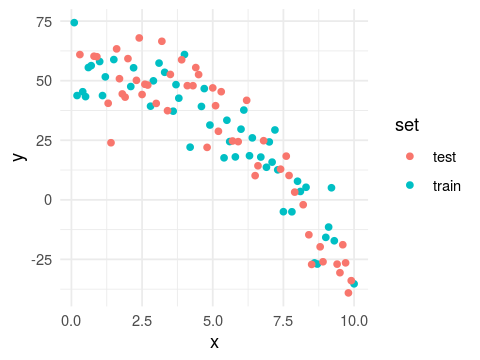

In [45]:
# We have shown that complex models produce overfitting: although their coefficients convege towards true values
# with many replications, individual samples produce coefficient estimates that are far off.
# In particular, complex models will perform better (as measured by the MSE) on fitted data on average, but
# comparatively worse on new data (testing dataset). You can check that with the simulation below by changing
# the complexity of the model (see the "polyorder" parameter below) and look at the impact on MSE of training and testing 
# datasets (next cell).

# One way to reduce overfitting is to "shrink" (= decrease) regressor coefficients artificially, by multiplying
# them by a constant <1. This will reduce the MSE discrepancy between training and testing datasets, but at the
# cost of increasing overall MSE a lot. You can check that by changing the "shrinkage" parameter below.

# Lasso and ridge regularizations are techniques that apply shrinkage in a much smarter way, adjusting the 
# strength of shrinkage on each coefficient independently, based on data. See next section.


# Define a pure quadratic relationship between two variables (without the noise)
b0 = 50
b1 = 3
b2 = -1.2
x = seq(0.1,10, .1)
y0 = b0 + b1*x + b2*x^2
n = length(x)

# Shrinkage coefficient
shrinkage = 0.8 # value between 0 and 1 (1 = no shrinkage)

# Model complexity (order of the fitted polynmial)
polyorder = 4

# Initialize vectors that will store the results
mse.train = vector("numeric",K)
mse.test = vector("numeric",K)

# Number of simulations
K = 1000

for (k in 1:K) {
    
    # Generate data by adding noise to the true model
    y = y0 + rnorm(n, 0, 10)

    # Split the sample in 2 equal train and test subsets
    idxtrain = sample.int(n, size = n/2, replace = F)
    idxtest = setdiff(seq(1,n),idxtrain)

    df = data.frame(x = c(x[idxtrain],x[idxtest]),
                             y = c(y[idxtrain],y[idxtest]),
                             set = c(rep("train",length(idxtrain)), rep("test",length(idxtest))))
    
    # Fit the model
    m <- lm(y ~ poly(x,polyorder), data = df %>% filter(set == "train"))
    
    # Apply shrinkage
    m$coefficients <- m$coefficients*shrinkage

    # Calculate MSE on fitted values (train dataset) and on the test dataset 
    mse.train[k] = mean((predict.lm(m, df %>% filter(set == "train")) - (df %>% filter(set == "train"))$y)^2)
    mse.test[k] = mean((predict.lm(m, df %>% filter(set == "test")) - (df %>% filter(set == "test"))$y)^2)
}


# Plot data
options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(data = df, aes(x = x, y = y, color = set)) +
geom_point()

[1] "Mean MSE on training data = 146.42"
[1] "Mean MSE on testing data = 162.07"
[1] "Inflation of MSE = 10.69%"
[1] "Percentage of models performing worse on testing data = 61.3%"


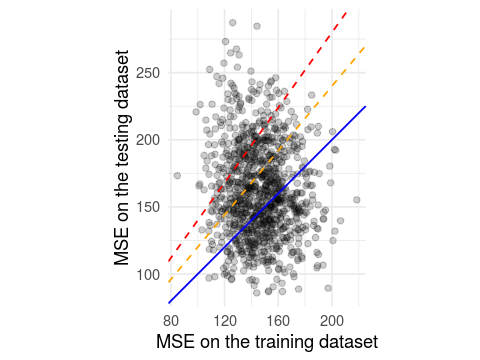

In [46]:
### Visualize results


df <- data.frame(mse.train, mse.test)

# Diplay some indices of performance

mean_mse.train = (df %>% summarise(mse.train = mean(mse.train)))$mse.train
mean_mse.test = (df %>% summarise(mse.test = mean(mse.test)))$mse.test

print(paste0("Mean MSE on training data = ", round(mean_mse.train,2)))
print(paste0("Mean MSE on testing data = ", round(mean_mse.test,2)))
print(paste0("Inflation of MSE = ", round(100*(mean_mse.test/mean_mse.train-1),2), "%"))

overfitting = (df %>% summarise(overfitting = mean(mse.test > mse.train)))$overfitting
print(paste0("Percentage of models performing worse on testing data = ", round(100*overfitting,2), "%"))

# => more shrinkage implies less variance (lower inflation of MSE) but more bias (increased mean MSE)

# Plot results
options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(data = df, aes(x = mse.train, y = mse.test)) +
geom_point(alpha = .2) +
geom_abline(intercept = 0, slope = 1, color = "blue") +
geom_abline(intercept = 0, slope = 1.2, linetype = 2, color = "orange") +
geom_abline(intercept = 0, slope = 1.4, linetype = 2, color = "red") +
coord_equal() +
labs(x = "MSE on the training dataset", y = "MSE on the testing dataset")

# Ridge and lasso regularizations

## Plot implicit prior distributions (Bayesian interpretation)

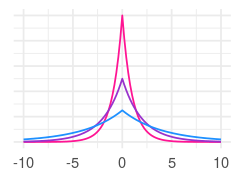

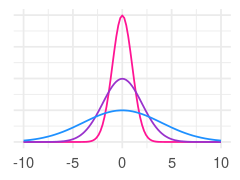

In [419]:
library(rmutil)

options(repr.plot.width = 2, repr.plot.height = 1.5)

ggplot(data.frame(), aes()) +
stat_function(fun = dlaplace, args = (list(s = 1)), color = "deeppink") +
stat_function(fun = dlaplace, args = (list(s = 2)), color = "darkorchid") +
stat_function(fun = dlaplace, args = (list(s = 4)), color = "dodgerblue") +
expand_limits(x = c(-10,10), y = 0) +
theme(axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.y = element_blank())


ggplot(data.frame(), aes()) +
stat_function(fun = dnorm, args = (list(s = 1)), color = "deeppink") +
stat_function(fun = dnorm, args = (list(s = 2)), color = "darkorchid") +
stat_function(fun = dnorm, args = (list(s = 4)), color = "dodgerblue") +
expand_limits(x = c(-10,10), y = 0) +
theme(axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.y = element_blank())

# Convert this notebook to R markdown

In [1]:
library(rmarkdown)
input = "2-05.ipynb"
rmarkdown:::convert_ipynb(input, output = xfun::with_ext(input, "Rmd"))